In [ ]:
%pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


/tmp/ipykernel_444641/2202526329.py:22: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  pose_df = pd.read_csv("static/pose_data_P6981_2025-06-20T15-29-16.csv")


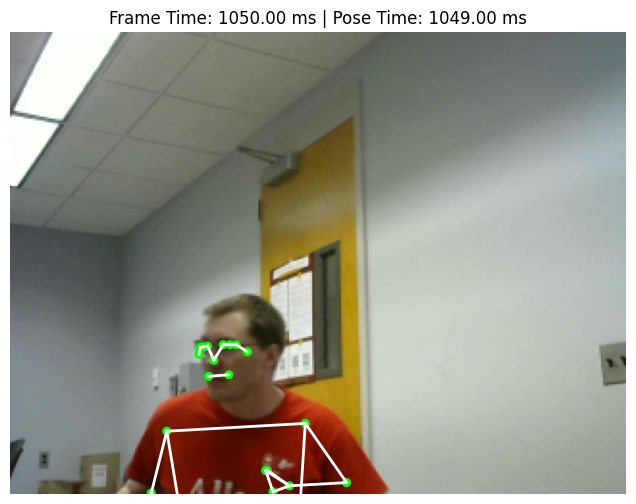

In [37]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10),
    (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
    (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
    (11, 23), (12, 24), (23, 24),
    (23, 25), (25, 27), (27, 29), (29, 31),
    (24, 26), (26, 28), (28, 30), (30, 32)
]


# Load pose data
pose_df = pd.read_csv("static/pose_data_P6981_2025-06-20T15-29-16.csv")
pose_df['frame_time_ms'] = pd.to_numeric(pose_df['frame_time_ms'], errors='coerce')

# Sort for safety
pose_df = pose_df.sort_values(by="frame_time_ms").reset_index(drop=True)

# Load video
cap = cv2.VideoCapture("static/webcam_recording_P6981_2025-06-20T15-29-16.webm")
if not cap.isOpened():
    raise IOError("Cannot open video")

# fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Function to draw pose


POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10),
    (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
    (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
    (11, 23), (12, 24), (23, 24),
    (23, 25), (25, 27), (27, 29), (29, 31),
    (24, 26), (26, 28), (28, 30), (30, 32)
]

def plot_pose_on_frame(frame, pose_row, ax=None, visibility_threshold=0.0):
    height, width = frame.shape[:2]
    landmark_count = 33
    landmarks = {}

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax.set_axis_off()

    # Gather landmark positions
    for i in range(landmark_count):
        x = pose_row.get(f'pose_{i}_x', np.nan)
        y = pose_row.get(f'pose_{i}_y', np.nan)
        vis = pose_row.get(f'pose_{i}_visibility', 1.0)

        if pd.notna(x) and pd.notna(y) and vis >= visibility_threshold:
            x_px = x * width
            y_px = y * height
            landmarks[i] = (x_px, y_px)
            ax.add_patch(Circle((x_px, y_px), radius=2, color='lime'))

    # Draw connectors
    for start, end in POSE_CONNECTIONS:
        if start in landmarks and end in landmarks:
            x0, y0 = landmarks[start]
            x1, y1 = landmarks[end]
            ax.add_line(Line2D([x0, x1], [y0, y1], linewidth=2, color='white'))


# Find frame closest to a given pose timestamp
def get_closest_pose(time_ms, window=33):  # ~1 frame at 30fps
    diffs = (pose_df['frame_time_ms'] - time_ms).abs()
    if diffs.min() <= window:
        return pose_df.iloc[diffs.idxmin()]
    return None  # No close match


# Read frames and overlay closest pose
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Get timestamp in ms for this frame
    frame_time_ms = cap.get(cv2.CAP_PROP_POS_MSEC)

    # pose_row = get_closest_pose(frame_time_ms, window=5)
    pose_row = get_closest_pose(frame_time_ms, window=1)

    if pose_row is not None:
        fig, ax = plt.subplots(figsize=(8, 6))
        plot_pose_on_frame(frame, pose_row, ax=ax)
        ax.set_title(f"Frame Time: {frame_time_ms:.2f} ms | Pose Time: {pose_row['frame_time_ms']:.2f} ms")
        plt.show()

        # Optional: break after one frame for testing
        break        
    else: 
        continue


cap.release()


In [21]:
# print(cv2.getBuildInformation())
